https://docs.dkrz.de/blog/2020/dask-dashboard.html

In [1]:
import dask
from dask.distributed import Client, LocalCluster

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

In [2]:
with dask.config.set({"distributed.scheduler.worker-saturation": 1.0}):
    #client = Client()
    client = Client(LocalCluster(local_directory='/scratch/b/b381258/')) 


2024-01-24 21:51:22,738 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/b/b381258/dask-worker-space/worker-cia3dy0n', purging


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b381258/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/b381258/levante-spawner-preset//proxy/8787/status,Workers: 9
Total threads: 54,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38127,Workers: 9
Dashboard: /user/b381258/levante-spawner-preset//proxy/8787/status,Total threads: 54
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:37135,Total threads: 6
Dashboard: /user/b381258/levante-spawner-preset//proxy/38525/status,Memory: 11.11 GiB
Nanny: tcp://127.0.0.1:36409,


In [4]:
import numpy as np
from scipy.interpolate import griddata  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import intake
import xarray as xr
import sys
import pandas as pd
import tempfile
from tqdm.auto import tqdm

In [7]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              256
On-line CPU(s) list: 0-255
Thread(s) per core:  2
Core(s) per socket:  64
Socket(s):           2
NUMA node(s):        8
Vendor ID:           AuthenticAMD
CPU family:          25
Model:               1
Model name:          AMD EPYC 7763 64-Core Processor
Stepping:            1
CPU MHz:             2450.000
CPU max MHz:         3529.0520
CPU min MHz:         1500.0000
BogoMIPS:            4900.18
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            32768K
NUMA node0 CPU(s):   0-15,128-143
NUMA node1 CPU(s):   16-31,144-159
NUMA node2 CPU(s):   32-47,160-175
NUMA node3 CPU(s):   48-63,176-191
NUMA node4 CPU(s):   64-79,192-207
NUMA node5 CPU(s):   80-95,208-223
NUMA node6 CPU(s):   96-111,224-239
NUMA node7 CPU(s):   112-127,240-255
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep 

In [5]:
root_path = '/work/ik1017/Catalogs/'
col_url = f"{root_path}mistral-cmip6.json"
col_url = f"{root_path}dkrz_cmip6_disk.json"
col = intake.open_esm_datastore(col_url)
col

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/intake_esm/cat.py:264: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,unique
activity_id,20
institution_id,39
source_id,103
experiment_id,214
member_id,479
table_id,39
variable_id,1164
grid_label,12
dcpp_init_year,63
version,753


In [48]:
models = []
models =  ['CanESM5']#, 'MPI-ESM1-2-LR']#,
#models = ['CNRM-CM6-1']#'IPSL-CM6A-LR']#, 'MPI-ESM1-2-LR'] # 'EC-Earth3' not working, 
#models = ['MPI-ESM1-2-HR', 'MIROC6', 'UKESM1-0-LL']
#models = ['MPI-ESM1-2-HR']
models = ['MIROC6']
#models = ['UKESM1-0-LL']
#models = ['INM-CM5-0']
#models =  ['CanESM5']
#models = ['IPSL-CM6A-LR']
 # NIMS-KMA.UKESM1-0 has one 1 ensemble member
    
sel_var = 'ua'# 'zg'
query = dict(experiment_id='historical', table_id='day', 
             variable_id=sel_var, source_id=models[:])#,grid_label='gn') # ssp585
cat = col.search(**query)
df = cat.df
k = df['activity_id'][0]+'_'+df['source_id'][0]+'_'+df['experiment_id'][0]+'_'+df['table_id'][0]+'_'+df['grid_label'][0]

In [49]:
cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,10
table_id,1
variable_id,1
grid_label,1
dcpp_init_year,0
version,1


In [50]:
df['time_range']

0       18500101-18501231
1       18510101-18511231
2       18520101-18521231
3       18530101-18531231
4       18540101-18541231
              ...        
1609    20100101-20101231
1610    20110101-20111231
1611    20120101-20121231
1612    20130101-20131231
1613    20140101-20141231
Name: time_range, Length: 1614, dtype: object

In [53]:
ls[-2]

['/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18500101-18501231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18510101-18511231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18520101-18521231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18530101-18531231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18540101-18541231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIROC6_historical_r8i1p1f1_gn_18550101-18551231.nc',
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/MIROC/MIROC6/historical/r8i1p1f1/day/ua/gn/v20191016/ua_day_MIR

In [51]:
ls = []
member_ls = df.member_id.unique()
#member_ls = member_ls[~np.isin(member_ls, ['r2i1p1f1','r8i1p1f1'])] for miroc6
for ens in tqdm(member_ls):
    mask = df.member_id == ens
    infiles = list(df[mask]['uri'].values)
    print(len(infiles))
    #ls.append(infiles)
    #if models[0] == 'IPSL-CM6A-LR': 
    #    ls.append([infiles[-1]])
    #else:
    ls.append(infiles)

  0%|          | 0/10 [00:00<?, ?it/s]

165
165
139
165
165
165
165
165
155
165


In [44]:
ls = []
member_ls = df.member_id.unique()
#member_ls = member_ls[~np.isin(member_ls, ['r2i1p1f1','r8i1p1f1'])] for miroc6
for ens in tqdm(member_ls):
    mask = df.member_id == ens
    infiles = list(df[mask]['uri'].values)
    print(len(infiles))
    #ls.append(infiles)
    #if models[0] == 'IPSL-CM6A-LR': 
    #    ls.append([infiles[-1]])
    #else:
    ls.append(infiles)
    #print(infiles)
    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = xr.open_mfdataset(
        ls, concat_dim = ['member_id','time'], 
        parallel = True, 
        combine='nested', 
        engine = 'netcdf4',
        chunks = chunk_dict[models[0]],#, time = 730)
        #**kwargsuse_cftime = False
    )
    ds['member_id'] = member_ls
    
ds

  0%|          | 0/35 [00:00<?, ?it/s]

17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


<xarray.Dataset>
Dimensions:    (time: 60225, member_id: 35, bnds: 2, plev: 8, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * member_id  (member_id) object 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member_id, time, bnds) object dask.array<chunksize=(1, 4015, 2), meta=np.ndarray>
    lat_bnds   (time, member_id, lat, bnds) float64 dask.array<chunksize=(4015, 1, 64, 2), meta=np.ndarray>
    lon_bnds   (time, member_id, lon, bnds) float64 dask.array<chunksize=(4015, 1, 128, 2), meta=np.ndarray>
    ua         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 4015, 1, 64, 128), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/a986bc3f-c258-4197-9c3f-137b9ff...
    variable_id:                 ua
    variant_label:               r10i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [46]:
ds_sel = ds.sel(
    plev = 1000,
    time = slice('1979', '2014')
).sel(lat = 60, method = 'nearest').mean('lon')
ds_sel

<xarray.Dataset>
Dimensions:    (time: 13140, member_id: 35, bnds: 2)
Coordinates:
  * time       (time) object 1979-01-01 12:00:00 ... 2014-12-31 12:00:00
    plev       float64 1e+03
    lat        float64 60.0
  * member_id  (member_id) object 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member_id, time, bnds) object dask.array<chunksize=(1, 730, 2), meta=np.ndarray>
    lat_bnds   (time, member_id, bnds) float64 dask.array<chunksize=(730, 1, 2), meta=np.ndarray>
    lon_bnds   (time, member_id, bnds) float64 dask.array<chunksize=(730, 1, 2), meta=np.ndarray>
    ua         (member_id, time) float32 dask.array<chunksize=(1, 730), meta=np.ndarray>

In [47]:
ds_sel_winter = ds_sel[[sel_var]].sel(time = np.isin(ds_sel.time.dt.month, [11,12,1,2,3,4])).squeeze().reset_coords(drop = True)
#sys.exit()
output = f'{outpath}CMIP6/including_April/{k}_{sel_var}_1979-2014.nc'
print(output)
ds_sel_winter.to_netcdf(output)

/work/bd1022/b381258/CMIP6/including_April/CMIP_CanESM5_historical_day_gn_ua_1979-2014.nc


In [44]:

directory = tempfile.gettempdir()

In [ ]:
# https://intake-esm.readthedocs.io/en/stable/how-to/modify-catalog.html
cat.serialize(directory='./catalogs/', name=f"my_catalog_subset_{models[0]}")

In [10]:
!cat /home/b/b381258/mistral_home/notebooks/('file', 'local'):///home/b/b381258/mistral_home/notebooks/catalogs/my_catalog_subset_INM-CM5-0.json

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cat /home/b/b381258/mistral_home/notebooks/('file', 'local'):///home/b/b381258/mistral_home/notebooks/catalogs/my_catalog_subset_INM-CM5-0.json'


In [9]:
!cat {directory}/my_catalog_subset.json

cat: {directory}/my_catalog_subset.json: No such file or directory


In [25]:
cat.serialize(directory=directory, name="my_catalog_subset", catalog_type="file")

NameError: name 'directory' is not defined

In [49]:
!cat {directory}/my_catalog_subset.csv

activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url,project,simulation_id,grid_id,frequency,time_reduction,long_name,units,realm,level_type,time_min,time_max,format,uri
CMIP,MOHC,UKESM1-0-LL,historical,r10i1p1f2,day,zg,gn,,v20191213,18500101-18991230,/work/ik1017/CMIP6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r10i1p1f2/day/zg/gn/v20191213/zg_day_UKESM1-0-LL_historical_r10i1p1f2_gn_18500101-18991230.nc,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/MOHC/UKESM1-0-LL/historical/r10i1p1f2/day/zg/gn/v20191213/zg_day_UKESM1-0-LL_historical_r10i1p1f2_gn_18500101-18991230.nc,CMIP6,r10i1p1f2,No entry,day, mean,Geopotential Height,m,atmos,,18500101.0,18991230,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r10i1p1f2/day/zg/gn/v20191213/zg_day_UKESM1-0-LL_historical_r10i1p1f2_gn_18500101-18991230.nc
CMIP,MOHC,UKESM1-0-LL,historical,r10i1p1f2,day,zg,gn,,v20191213,19000101-19491230,/w

In [13]:
chunk_dict = {
    'UKESM1-0-LL':  dict(plev = 1, time = 1800),
    'MIROC6': {},
    'MPI-ESM1-2-HR': dict(plev = 1),
    'CanESM5': dict(plev = 1),
    'CNRM-CM6-1': dict(plev = 1, time = 2000),
    'IPSL-CM6A-LR': dict(plev = 1, time = 3000),
    'INM-CM5-0': dict(plev = 1),
}

In [ ]:
https://easy.gems.dkrz.de/Processing/Intake/find_files.html#using-time-ranges
--time_range 2020-02-01 2020-02-03
df = hitlist.df[
            (hitlist.df["time_min"] <= tr[1]) * (hitlist.df["time_max"] >= tr[0])
        ]

In [30]:
df["time_min"]

0     19500101.0
1     19750101.0
2     20000101.0
3     19500101.0
4     19750101.0
         ...    
73    19750101.0
74    20000101.0
75    19500101.0
76    19750101.0
77    20000101.0
Name: time_min, Length: 78, dtype: object

In [14]:
ls = []
member_ls = df.member_id.unique()
for ens in tqdm(member_ls):
    mask = df.member_id == ens
    infiles = list(df[mask]['uri'].values)
    print(len(infiles))
    #ls.append(infiles)
    if models[0] == 'IPSL-CM6A-LR': 
        ls.append([infiles[-1]])
    else:
        ls.append(infiles)
    #print(infiles)
    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = xr.open_mfdataset(
        ls, concat_dim = ['member_id','time'], 
        parallel = True, 
        combine='nested', 
        engine = 'netcdf4',
        chunks = chunk_dict[models[0]],#, time = 730)
        #**kwargsuse_cftime = False
    )
    ds['member_id'] = member_ls

  0%|          | 0/10 [00:00<?, ?it/s]

33
33
33
33
33
33
33
33
33
33


In [15]:
ds

<xarray.Dataset>
Dimensions:    (time: 60225, member_id: 10, bnds: 2, plev: 8, lat: 120, lon: 180)
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat        (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * member_id  (member_id) object 'r10i1p1f1' 'r1i1p1f1' ... 'r9i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member_id, time, bnds) object dask.array<chunksize=(1, 1825, 2), meta=np.ndarray>
    lat_bnds   (time, member_id, lat, bnds) float64 dask.array<chunksize=(1825, 1, 120, 2), meta=np.ndarray>
    lon_bnds   (time, member_id, lon, bnds) float64 dask.array<chunksize=(1825, 1, 180, 2), meta=np.ndarray>
    zg         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 1825, 1, 120, 180), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  381060.0
    contact:                Evgeny Volodin (volodinev@gmail.com)
    ...                     ...
    title:                  INM-CM5-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/c2ef1014-8125-4905-b0fe-db72adc75cf8
    variable_id:            zg
    variant_label:          r10i1p1f1
    license:                CMIP6 model data produced by Lawrence Livermore P...
    cmor_version:           3.4.0

# Selection and calculation

In [16]:
A = 6374.0e3       # Earth radius
DEGRAD = np.pi/180. # conversion of degrees to radians
RADDEG = 180./np.pi # conversion of radians to degrees 

#optimized
def sph_to_car(field, lons, lats, xypoints,resolution):
    nlons = len(lons)
    nlats = len(lats)
    xyvals = []
    """for ilon in range(nlons): # -1s needed?
        for ilat in range(nlats):
            xyvals.append(field[ilat,ilon])"""
    xyvals = field.reshape(nlons*nlats, order='F')

    if resolution == 'full':       
        cart_x_points = -1.+np.arange(nlons)/(0.5*nlons)             
        cart_y_points = -1.+np.arange(nlons)/(0.5*nlons)
    elif resolution == 'low':
        cart_x_points = -1.+np.arange(50)/(0.5*50)
        cart_y_points = -1.+np.arange(50)/(0.5*50)
    else:
        raise ValueError()
    
    cart_gridx, cart_gridy = np.meshgrid(cart_x_points,cart_y_points)

    field_cart = griddata(xypoints, np.array(xyvals), (cart_gridx,cart_gridy), \
                        method='linear')  # Might want to change to cubic etc?
                              
    return field_cart, cart_x_points, cart_y_points  
#the same
def isolate_vortex(field_cart, edge, field_type='GPH'):
    """
    Replace vortex into region (outside) equal to field on vortex edge, and 
    region (inside) with values of vortex. 
    For GPH vortex is less than surrounding, for PV it is greater. 
    """
    if field_type == 'GPH':
        field_cart[np.where(field_cart > edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge 
    elif field_type == 'PV':
        field_cart[np.where(field_cart < edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge
    else:
        raise ValueError() # maybe want more specific error type

    return field_cart

def moment_integrate2(vtx_field, x, y,edge):
    """
    Performs moment diagnostic calculations on cartesian field
    """

    # x and y are cartesian gridpoints; vtx_field is cartesian field
    # edge is value on vortex edge 

    box_length = 2*A/len(x)
    box_area = box_length**2

    # Set up moment diagnostics
    M00 = 0
    M10 = 0
    M01 = 0
    Marea = 0
    # Integrate over vortex
          
    M00 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0))
    M10 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**1)*(y[np.newaxis,:]**0))
    M01 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**1))
    Marea = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0)*box_area)
            
    # Calculate centroid 
    centx = M10/M00
    centy = M01/M00

    # Convert back to polar coordinates 
    R = centx**2 + centy**2
    latcent = np.arcsin((1-R)/(1+R))*RADDEG
    loncent = np.arctan(centx/centy)*RADDEG
    
    # Set up relative moment diagnostics 
    J11 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**1)*((y[np.newaxis,:]-centy)**1))
    J20 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**2)*((y[np.newaxis,:]-centy)**0))
    J02 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**0)*((y[np.newaxis,:]-centy)**2))
    J22 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**2)*((y[np.newaxis,:]-centy)**2))
    J40 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**4)*((y[np.newaxis,:]-centy)**0))
    J04 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**0)*((y[np.newaxis,:]-centy)**4))  

    
      # Calculate angle between x-axis and major axis of ellipse                  
    angle = 0.5*np.arctan((2*J11)/(J20-J02))*RADDEG
    
    # Calculate aspect ratio
    ar = np.sqrt(abs(( (J20+J02) + np.sqrt(4*(J11**2)+(J20-J02)**2) ) / \
                               ( (J20+J02) - np.sqrt(4*(J11**2)+(J20-J02)**2) ))) 
    
    objective_area = Marea/edge 
    
    # Calculate excess kurtosis 
    kurtosis = M00 * (J40+2*J22+J04)/((J20+J02)**2) \
                         - (2./3.)*( (3*(ar**4)+2*(ar**2)+3) / (((ar**2)+1)**2) ) 
    
    return angle, ar, objective_area, kurtosis, latcent, loncent 

def calc_moments(field, lats, lons, xypoints, hemisphere='NH', field_type='GPH', \
                 edge=3.02e4, resolution='full'):
    field_cart, x, y = sph_to_car(field,lons,lats,xypoints,resolution)
    field_vtx = isolate_vortex(field_cart, edge, field_type)
   
    #angle, aspect_ratio, objective_area, kurtosis, latcent, loncent = moment_integrate2(field_vtx, x, y,edge)
        
    #return {'aspect_ratio':aspect_ratio, 'centroid_latitude': latcent, 'centroid'}
    values = moment_integrate2(field_vtx, x, y, edge)
    return values
                 
def calc_xypoints(lons, lats):
    DEGRAD = np.pi/180.
    lons = lons * DEGRAD
    lats = lats * DEGRAD
    x = (np.cos(lons[:,np.newaxis])*np.cos(lats))/ (1. + np.sin(lats[np.newaxis,:]))               
    y = (np.sin(lons[:,np.newaxis])*np.cos(lats[np.newaxis,:]))/(1. + np.sin(lats[np.newaxis,:]))
    nlon_nlat = lons.shape[0]*lats.shape[0]
    xypoints = np.stack([x.reshape(nlon_nlat),y.reshape(nlon_nlat)], axis = 1)
    return xypoints
                 
def moments_fce(arr, edge=3.02e4):
    moments = calc_moments(arr, lats, lons, xypoints, 'NH','GPH', edge)
    return np.array(moments) #np.array([moments['aspect_ratio'], moments['centroid_latitude']])


In [17]:
user = 'b381258'
outpath=f'/work/bd1022/{user}/'
winter_month_ls = [11,12,1,2,3,4]



ds_sel = ds['zg'].sel(
    plev = 1000,#[10000,5000,1000],
    time =slice('1979-01-01',None), #slice('1920-01-01',None),#time = slice(None,'2100-12-31'),
    lat = slice(20,None)
)
ds_sel_winter = ds_sel.sel(
time = np.isin(
ds_sel.time.dt.month, 
winter_month_ls
))

#output = f'{outpath}CMIP6/{k}_zg@10and100hPa.nc'


lons = ds_sel.lon.values
lats = ds_sel.lat.values
xypoints = calc_xypoints(lons,lats)

temp = ds_sel_winter.sel(lat = 60, method = 'nearest').mean(['lon','time'])#.load() # 
#print(temp)
#sys.exit()
dask_gufun_dict = dict(output_sizes = dict(vars = 6))
moments_xr = xr.apply_ufunc(moments_fce, ds_sel_winter, temp, \
                        input_core_dims=[['lat', 'lon'], []], \
                        output_core_dims=[['vars']], \
                        output_dtypes = [float], vectorize=True, \
                        dask = 'parallelized',\
                        dask_gufunc_kwargs = dask_gufun_dict)#.compute()


moments_xr['vars'] = ['angle', 'aspect_ratio', 'objective_area', 'kurtosis', 'centroid_latitude', 'centroid_longitude']#.reset_coords()
moments_ds = moments_xr.to_dataset(dim = 'vars') #.reset_coords('vars')


#sys.exit()
output = f'{outpath}CMIP6/including_April/{k}_moments@10hPa.nc'
print(output)


moments_ds.to_netcdf(output)
    

/work/bd1022/b381258/CMIP6/including_April/CMIP_INM-CM5-0_historical_day_gr1_moments@10hPa.nc


/tmp/ipykernel_378318/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_378318/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipyke

In [ ]:
client

In [56]:
import kerchunk.hdf

ModuleNotFoundError: No module named 'kerchunk.hdf'

2024-01-24 17:11:00,753 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2024-01-24 17:11:00,754 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-24 17:11:00,755 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-24 17:11:00,755 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-24 17:11:00,756 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing


In [66]:
moments_ds['aspect_ratio'][:,:365]

<xarray.DataArray 'aspect_ratio' (member_id: 17, time: 365)>
dask.array<getitem, shape=(17, 365), dtype=float64, chunksize=(1, 185), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1979-01-01 12:00:00 ... 1981-01-05 12:00:00
    plev       float64 1e+03
  * member_id  (member_id) object 'r10i1p1f2' 'r11i1p1f2' ... 'r14i1p1f2'

/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars


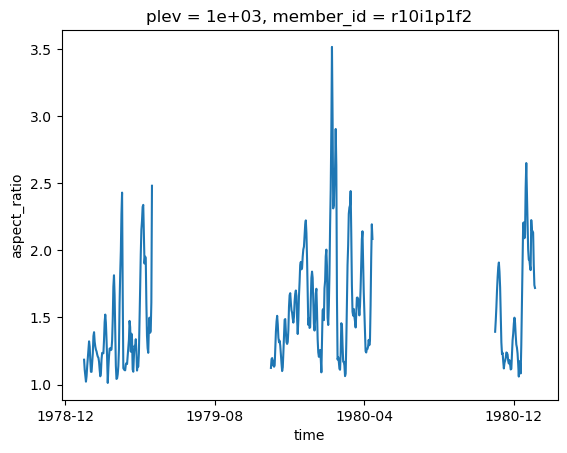

In [68]:
moments_ds['aspect_ratio'][0,:365].plot()

/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars


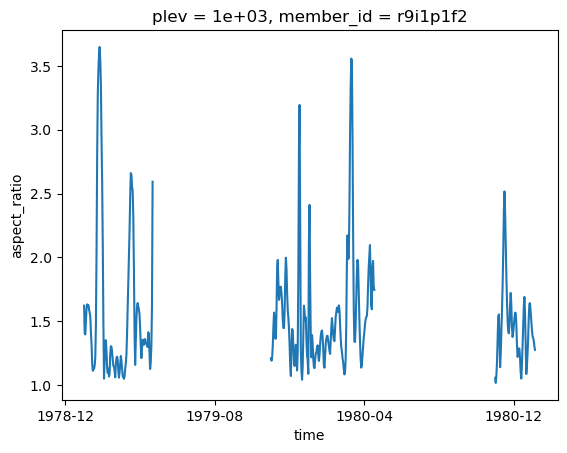

In [71]:
moments_ds['aspect_ratio'].sel(member_id = 'r9i1p1f2')[:365].plot()

/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars


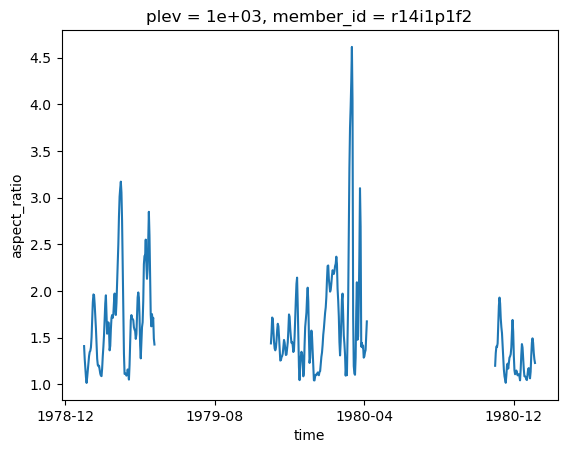

In [69]:
moments_ds['aspect_ratio'][-1,:365].plot()

In [65]:
moments_ds['aspect_ratio'][:,:365].plot()

/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_173444/698317998.py:73: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipyke

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.